## Up-Sampling -  #700055807

In [2]:
#importing all modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,fbeta_score, precision_score,accuracy_score, confusion_matrix, auc
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
#importing white wine data set (UCI https://archive.ics.uci.edu/ml/datasets/wine+quality)

wine_df = pd.read_csv('data/winequality-white.csv', sep=';')

data = wine_df.copy()

In [4]:
#Creating the catigorical target, less than 8 as 0 and more than 8 as 1

data['type'] = np.where(data['quality'] < 8, 'bad', 'good')


In [5]:
# using the enconder to code 0,1 for bad and good respectvily 

le = LabelEncoder()
data['target'] = le.fit_transform(data['type'])

In [6]:
data[data['target'] == 0].shape

(4718, 14)

In [7]:
data[data['target'] == 1].shape

(180, 14)

In [8]:
data['type'].value_counts(normalize=True)* 100

bad     96.325031
good     3.674969
Name: type, dtype: float64

In [9]:
X = data.iloc[:,:-3]

In [10]:
y = data.iloc[:,-1]

### Splitting for x and y train up-sampling

In [11]:
#splitting data for y_test, and X_test only
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)


In [12]:
#creating upsampling for X_train and y_train
class_1 = X_train[y_train == 1]

In [13]:
class_0 = X_train[y_train==0]

In [14]:
class_1['target'] = y_train[y_train == 1]

<ipython-input-14-35262d94dc1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_1['target'] = y_train[y_train == 1]


In [15]:
class_0['target'] = y_train[y_train == 0]

<ipython-input-15-f3588194e66d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_0['target'] = y_train[y_train == 0]


In [16]:
#using resample to upsample for the minority class
majority_class_size = class_0['target'].shape[0]
majority_class_size
from sklearn.utils import resample

class_1_resampled = resample(class_1, n_samples=majority_class_size)
class_1_resampled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
3253,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.8,1
1218,7.2,0.26,0.44,7.1,0.027,25.0,126.0,0.99300,3.02,0.34,11.1,1
2965,5.5,0.34,0.26,2.2,0.021,31.0,119.0,0.98919,3.55,0.49,13.0,1
1464,8.0,0.44,0.49,9.1,0.031,46.0,151.0,0.99260,3.16,0.27,12.7,1
3449,6.6,0.15,0.32,6.0,0.033,59.0,128.0,0.99192,3.19,0.71,12.1,1


In [17]:
resampled_data = pd.concat([class_0, class_1_resampled], axis=0)

In [18]:
resampled_data['target'].value_counts()

1    3536
0    3536
Name: target, dtype: int64

In [19]:
#X_train_upsampled and y_train_upsampled ready
x_train_resampled = np.array(resampled_data.iloc[:,:-1])

In [20]:
y_train_resampled = np.array(resampled_data.iloc[:,-1])

In [21]:
# running the classifiers for the Upsampling

model_scores = {}
model_roc_scores = {}
model_fbeta_score = {}
precision_scores = {}

DT_re = DecisionTreeClassifier()
log_re = LogisticRegression()
RF = RandomForestClassifier()

for model in [DT_re, log_re, RF]:
    model.fit(x_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    model_scores[model] = score
    
    y_pred_proba = model.predict_proba(X_test)
    roc = roc_auc_score(y_test, y_pred_proba[:,1])
    model_roc_scores[model] = roc
    
    y_pred_proba = model.predict_proba(X_test)
    fb_score = fbeta_score(y_test, y_pred, beta=0.5)
    model_fbeta_score[model] = fb_score
    
    y_pred = model.predict(X_test)
    p_score = precision_score(y_test, y_pred)
    precision_scores[model] = p_score
    
    
model_scores
model_roc_scores
model_fbeta_score
precision_scores

roc_df = pd.DataFrame(list(model_roc_scores.items()),columns = ['Model','Roc Auc Score']) 
scores_df = pd.DataFrame(list(model_scores.items()),columns = ['Model1','Accuracy Score'])
precision_scores_df = pd.DataFrame(list(precision_scores.items()), columns=['Model3','Precision Score'])
fbeta_scores_df = pd.DataFrame(list(model_fbeta_score.items()), columns=['Model2','F_beta Score'])

#creating the df for comparing the classifiers
total_scores_df = pd.concat([roc_df,scores_df ,precision_scores_df, fbeta_scores_df], axis=1)
total_scores_df.drop(['Model1', 'Model2', 'Model3'], axis=1, inplace=True)
total_scores_df.index.name = 'TOMEK Sampling'
total_scores_df = total_scores_df.round(2)
total_scores_df.index = ['DecisionTreeClassifier', 'LogisticRegression', 'RandomForestClassifier']
total_scores_df

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,DecisionTreeClassifier(),0.70,0.96,0.40,0.4
LogisticRegression,LogisticRegression(),0.80,0.68,0.08,0.1
RandomForestClassifier,"(DecisionTreeClassifier(max_features='auto', r...",0.91,0.98,0.94,0.7


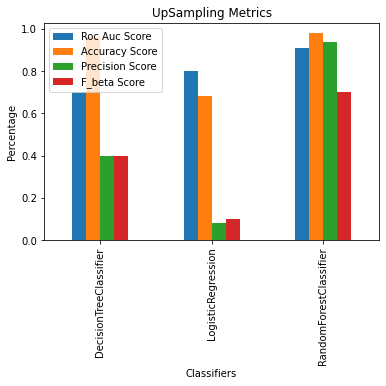

In [22]:
#plotting the comparison - upsampling

total_scores_df.plot(kind='bar')
plt.title('UpSampling Metrics')
plt.ylabel('Percentage')
plt.xlabel('Classifiers')
plt.show()

In [23]:
#compare final df
total_scores_df.drop('Model', axis=1)


,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,0.70,0.96,0.40,0.4
LogisticRegression,0.80,0.68,0.08,0.1
RandomForestClassifier,0.91,0.98,0.94,0.7


In [24]:
#testing confusin matrix
DT_re = DecisionTreeClassifier()
DT_re.fit(x_train_resampled, y_train_resampled)
y_pred_DT = DT_re.predict(X_test)

In [25]:
accuracy_score(y_test, y_pred_DT)
print(classification_report(y_test, y_pred_DT))
print(fbeta_score(y_test, y_pred_DT, beta=0.5))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1182
           1       0.35      0.42      0.38        43

    accuracy                           0.95      1225
   macro avg       0.66      0.69      0.68      1225
weighted avg       0.96      0.95      0.95      1225

0.3585657370517929


Text(33.0, 0.5, 'True Label')

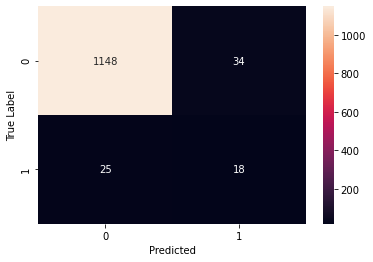

In [26]:
DT_resampled = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(DT_resampled, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True Label')

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.695


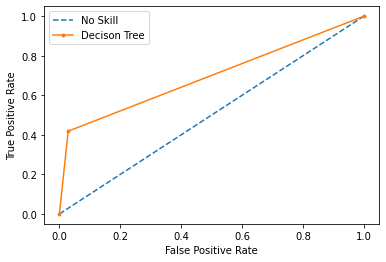

In [27]:
#AUC for DT

ns_probs = [0 for _ in range(len(y_test))]
y_pred_DT_proba = DT_re.predict_proba(X_test)
DT_probs = y_pred_DT_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
DT_auc = roc_auc_score(y_test, DT_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (DT_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
DT_fpr, DT_tpr, _ = roc_curve(y_test, DT_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(DT_fpr, DT_tpr, marker='.', label='Decison Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [79]:
RF = RandomForestClassifier()
RF.fit(x_train_resampled, y_train_resampled)
y_pred_RF = RF.predict(X_test)
accuracy_score(y_test, y_pred_RF)

0.9746938775510204

In [141]:
print(classification_report(y_test, y_pred_RF))
print(fbeta_score(y_test, y_pred_RF, beta=0.5))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1182
           1       0.80      0.37      0.51        43

    accuracy                           0.97      1225
   macro avg       0.89      0.68      0.75      1225
weighted avg       0.97      0.97      0.97      1225

0.6504065040650407


Text(33.0, 0.5, 'True Label')

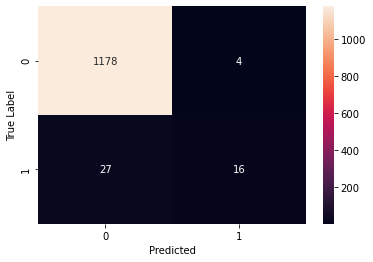

In [81]:
RF_resampled = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(RF_resampled, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [102]:
y_pred_RF_proba

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [0.76, 0.24],
       ...,
       [0.98, 0.02],
       [0.84, 0.16],
       [0.96, 0.04]])

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.894


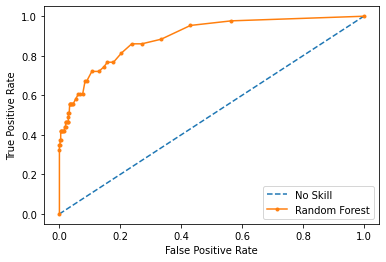

In [103]:
#AUC for RF
ns_probs = [0 for _ in range(len(y_test))]
y_pred_RF_proba = RF.predict_proba(X_test)
RF_probs = y_pred_RF_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
RF_auc = roc_auc_score(y_test, RF_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (RF_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
RF_fpr, RF_tpr, _ = roc_curve(y_test, RF_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [82]:
log_re = LogisticRegression()
log_re.fit(x_train_resampled, y_train_resampled)
y_pred_log = log_re.predict(X_test)
accuracy_score(y_test, y_pred_log)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.686530612244898

In [142]:
print(classification_report(y_test, y_pred_log))
print(fbeta_score(y_test, y_pred_log, beta=0.5))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81      1182
           1       0.08      0.74      0.14        43

    accuracy                           0.69      1225
   macro avg       0.53      0.71      0.48      1225
weighted avg       0.95      0.69      0.78      1225

0.0962116656644618


In [91]:
r_auc = roc_auc_score(y_test, lr_probs)
r_auc

0.793176720576083

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.793


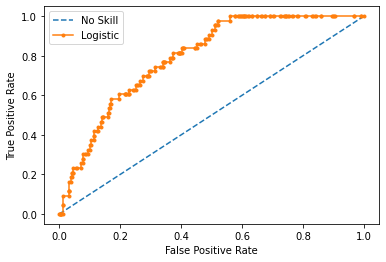

In [100]:
#AUC for Logistic

ns_probs = [0 for _ in range(len(y_test))]
y_pred_log_proba = log_re.predict_proba(X_test)
lr_probs = y_pred_log_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

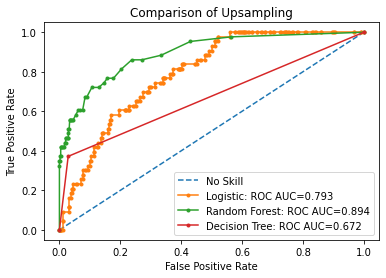

In [137]:
#AUC for all

ns_probs = [0 for _ in range(len(y_test))]
y_pred_log_proba = log_re.predict_proba(X_test)
lr_probs = y_pred_log_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
#print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest: ROC AUC=%.3f' % (RF_auc))
plt.plot(DT_fpr, DT_tpr, marker='.', label='Decision Tree: ROC AUC=%.3f' % (DT_auc))

# axis labels
plt.title('Comparison of Upsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()